In [1]:
import os
from PIL import Image
import numpy as np

from torch.utils.data import Dataset



class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor

        self.img_dir = os.path.join(self.root_dir, "images")
        self.ann_dir = os.path.join(self.root_dir, "annotations")
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          print(files)
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        annotation = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # make 2D segmentation map (based on 3D one)
        # thanks a lot, Stackoverflow: https://stackoverflow.com/questions/61897492/finding-the-number-of-pixels-in-a-numpy-array-equal-to-a-given-color
        annotation = np.array(annotation)
        annotation_2d = np.zeros((annotation.shape[0], annotation.shape[1]), dtype=np.uint8) # height, width

        for id, color in id2color.items():
            annotation_2d[(annotation == color).all(axis=-1)] = id

        # randomly crop + pad both image and segmentation map to same size
        # feature extractor will also reduce labels!
        encoded_inputs = self.feature_extractor(image, Image.fromarray(annotation_2d), return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [2]:
import pandas as pd

# read in RUGD's color palette
color_map = pd.read_csv('RUGD_annotation-colormap.txt',
                              sep=" ",
                              header=None)
color_map.columns = ["label_idx", "label", "R", "G", "B"]
color_map.head()

,label_idx,label,R,G,B
0,0,void,0,0,0
1,1,dirt,108,64,20
2,2,sand,255,229,204
3,3,grass,0,102,0
4,4,tree,0,255,0


In [3]:
label2id = {label: id for id, label in enumerate(color_map.label)}
id2label = {id: label for id, label in enumerate(color_map.label)}
print(id2label)

{0: 'void', 1: 'dirt', 2: 'sand', 3: 'grass', 4: 'tree', 5: 'pole', 6: 'water', 7: 'sky', 8: 'vehicle', 9: 'container/generic-object', 10: 'asphalt', 11: 'gravel', 12: 'building', 13: 'mulch', 14: 'rock-bed', 15: 'log', 16: 'bicycle', 17: 'person', 18: 'fence', 19: 'bush', 20: 'sign', 21: 'rock', 22: 'bridge', 23: 'concrete', 24: 'picnic-table'}


In [4]:
len(id2label)

25

In [5]:
id2color = {id: [R,G,B] for id, (R,G,B) in enumerate(zip(color_map.R, color_map.G, color_map.B))}
print(id2color)

{0: [0, 0, 0], 1: [108, 64, 20], 2: [255, 229, 204], 3: [0, 102, 0], 4: [0, 255, 0], 5: [0, 153, 153], 6: [0, 128, 255], 7: [0, 0, 255], 8: [255, 255, 0], 9: [255, 0, 127], 10: [64, 64, 64], 11: [255, 128, 0], 12: [255, 0, 0], 13: [153, 76, 0], 14: [102, 102, 0], 15: [102, 0, 0], 16: [0, 255, 128], 17: [204, 153, 255], 18: [102, 0, 204], 19: [255, 153, 204], 20: [0, 102, 102], 21: [153, 204, 255], 22: [102, 255, 255], 23: [101, 101, 11], 24: [114, 85, 47]}


In [6]:
id2color[label2id["tree"]]

[0, 255, 0]

Let's initialize the training dataset. 

As we can see above, the dataset includes a "void" class (with id=0). However, this class isn't included in the annotation maps (the "void" class isn't part of the 24 labels), hence we initialize the feature extractor with `reduce_labels=True` to make it reduce all labels by one.

This makes sure that the ground truth label tensors contain values between 0 and 23.



In [7]:
import glob

In [8]:
from transformers import SegformerFeatureExtractor

root_dir = 'data'
feature_extractor = SegformerFeatureExtractor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)

['creek_00001.png', 'creek_00006.png', 'creek_00011.png', 'creek_00016.png', 'creek_00021.png', 'creek_00026.png', 'creek_00031.png', 'creek_00036.png', 'creek_00041.png', 'creek_00046.png', 'creek_00051.png', 'creek_00056.png', 'creek_00061.png', 'creek_00066.png', 'creek_00071.png', 'creek_00076.png', 'creek_00081.png', 'creek_00086.png', 'creek_00091.png', 'creek_00096.png', 'creek_00101.png', 'creek_00106.png', 'creek_00111.png', 'creek_00116.png', 'creek_00121.png', 'creek_00126.png', 'creek_00131.png', 'creek_00136.png', 'creek_00141.png', 'creek_00146.png', 'creek_00151.png', 'creek_00156.png', 'creek_00161.png', 'creek_00166.png', 'creek_00171.png', 'creek_00176.png', 'creek_00181.png', 'creek_00186.png', 'creek_00191.png', 'creek_00196.png', 'creek_00201.png', 'creek_00206.png', 'creek_00211.png', 'creek_00216.png', 'creek_00221.png', 'creek_00226.png', 'creek_00231.png', 'creek_00236.png', 'creek_00241.png', 'creek_00246.png', 'creek_00251.png', 'creek_00256.png', 'creek_0026

c:\Users\GPUSW1\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [10]:
print("Number of training examples:", len(train_dataset))

Number of training examples: 7436


Let's verify a random example:

In [11]:
encoded_inputs = train_dataset[0]

In [12]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [13]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [14]:
encoded_inputs["labels"]

tensor([[ 3,  3,  3,  ...,  3,  3,  3],
        [ 3,  3,  3,  ...,  3,  3,  3],
        [ 3,  3,  3,  ...,  3,  3,  3],
        ...,
        [ 1,  1,  1,  ..., 13, 13, 13],
        [ 1,  1,  1,  ..., 13, 13, 13],
        [ 1,  1,  1,  ..., 13, 13, 13]])

In [15]:
encoded_inputs["labels"].squeeze().unique()

tensor([ 0,  1,  2,  3,  5,  6,  7,  8, 13, 18, 20, 21])

Next, we define a corresponding dataloader.

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [17]:
batch = next(iter(train_dataloader))

In [18]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([16, 3, 512, 512])
labels torch.Size([16, 512, 512])


In [19]:
batch["labels"].shape

torch.Size([16, 512, 512])

In [20]:
mask = (batch["labels"] != 255)
mask

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

In [21]:
batch["labels"][mask]

tensor([ 3,  3,  3,  ..., 10, 10, 10])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

As we've reduced all labels by one above, we need to update our `id2color` and `id2label` mappings first.

In [22]:
del id2color[0]

id2color = {id-1: color for id, color in id2color.items()}
print(id2color)

{0: [108, 64, 20], 1: [255, 229, 204], 2: [0, 102, 0], 3: [0, 255, 0], 4: [0, 153, 153], 5: [0, 128, 255], 6: [0, 0, 255], 7: [255, 255, 0], 8: [255, 0, 127], 9: [64, 64, 64], 10: [255, 128, 0], 11: [255, 0, 0], 12: [153, 76, 0], 13: [102, 102, 0], 14: [102, 0, 0], 15: [0, 255, 128], 16: [204, 153, 255], 17: [102, 0, 204], 18: [255, 153, 204], 19: [0, 102, 102], 20: [153, 204, 255], 21: [102, 255, 255], 22: [101, 101, 11], 23: [114, 85, 47]}


In [23]:
del id2label[0]

label2id = {label: id-1 for id, label in id2label.items()}
id2label = {id-1: label for id, label in id2label.items()}
print(id2label)

{0: 'dirt', 1: 'sand', 2: 'grass', 3: 'tree', 4: 'pole', 5: 'water', 6: 'sky', 7: 'vehicle', 8: 'container/generic-object', 9: 'asphalt', 10: 'gravel', 11: 'building', 12: 'mulch', 13: 'rock-bed', 14: 'log', 15: 'bicycle', 16: 'person', 17: 'fence', 18: 'bush', 19: 'sign', 20: 'rock', 21: 'bridge', 22: 'concrete', 23: 'picnic-table'}


In [24]:
from transformers import SegformerForSemanticSegmentation

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=24, 
                                                         id2label=id2label, 
                                                         label2id=label2id,
)

Downloading:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

c:\Users\GPUSW1\AppData\Local\Programs\Python\Python38\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\GPUSW1\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear

## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [25]:
from datasets import load_metric

metric = load_metric("mean_iou")

C:\Users\GPUSW1\AppData\Local\Temp\ipykernel_13028\827884743.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("mean_iou")


In [26]:
import torch
torch.cuda.is_available()

True

In [27]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(10):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
  
        labels = batch["labels"].to(device)
 

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)
          
          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # we use _compute for now which fixes an issue in speed
          # see this Github thread for more info: 
          metrics = metric._compute(num_labels=len(id2label), 
                                   ignore_index=255,
                                   reduce_labels=False, # we've already reduced the labels before)
                                   predictions=predicted.detach().cpu().numpy(),
                                    references=labels.detach().cpu().numpy()
          )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/465 [00:00<?, ?it/s]

C:\Users\GPUSW1\.cache\huggingface\modules\datasets_modules\metrics\mean_iou\d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 3.118713617324829
Mean_iou: 0.017680302092302938
Mean accuracy: 0.042752798884170884


C:\Users\GPUSW1\.cache\huggingface\modules\datasets_modules\metrics\mean_iou\d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342\mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union


Loss: 1.2355140447616577
Mean_iou: 0.16402907444374107
Mean accuracy: 0.23574674712447577
Loss: 0.7718181014060974
Mean_iou: 0.3190446669218985
Mean accuracy: 0.39030904785216036
Loss: 0.5425694584846497
Mean_iou: 0.38663029210852834
Mean accuracy: 0.4345959754328504
Loss: 0.44098031520843506
Mean_iou: 0.35442239944174503
Mean accuracy: 0.44444744688873233
Epoch: 1


  0%|          | 0/465 [00:00<?, ?it/s]

Loss: 0.5592591762542725
Mean_iou: 0.4338375294461778
Mean accuracy: 0.48342845323673095
Loss: 0.30022943019866943
Mean_iou: 0.46831553013296
Mean accuracy: 0.5426003200992057
Loss: 0.3117401897907257
Mean_iou: 0.32847934755202224
Mean accuracy: 0.42167456288878047
Loss: 0.3035436272621155
Mean_iou: 0.45806510619271984
Mean accuracy: 0.5079636644113987
Loss: 0.43862584233283997
Mean_iou: 0.40250301378082265
Mean accuracy: 0.46473670268951217
Epoch: 2


  0%|          | 0/465 [00:00<?, ?it/s]

Loss: 0.3109833598136902
Mean_iou: 0.35764185773387897
Mean accuracy: 0.45649946858280116
Loss: 0.3025979697704315
Mean_iou: 0.5239222894269817
Mean accuracy: 0.6051894067931866
Loss: 0.27637168765068054
Mean_iou: 0.4476437256707381
Mean accuracy: 0.5029148993436549
Loss: 0.26742950081825256
Mean_iou: 0.5145249950391753
Mean accuracy: 0.6281400883092013
Loss: 0.2722066342830658
Mean_iou: 0.492970309456022
Mean accuracy: 0.5456850552084938
Epoch: 3


  0%|          | 0/465 [00:00<?, ?it/s]

Loss: 0.2430499792098999
Mean_iou: 0.4802075685126732
Mean accuracy: 0.5511407618210478
Loss: 0.21277549862861633
Mean_iou: 0.4947692480702557
Mean accuracy: 0.5888636313794801
Loss: 0.38415291905403137
Mean_iou: 0.5193570462490391
Mean accuracy: 0.5887847416846197
Loss: 0.21810726821422577
Mean_iou: 0.5640876050502688
Mean accuracy: 0.6704980337274932
Loss: 0.24392597377300262
Mean_iou: 0.4786099311269078
Mean accuracy: 0.5755090614219465
Epoch: 4


  0%|          | 0/465 [00:00<?, ?it/s]

Loss: 0.24948641657829285
Mean_iou: 0.5136883251080056
Mean accuracy: 0.6091469356840453
Loss: 0.2939938008785248
Mean_iou: 0.5331739929292196
Mean accuracy: 0.6057603643171168
Loss: 0.2882651090621948
Mean_iou: 0.4610469009530816
Mean accuracy: 0.5578003418558933
Loss: 0.22947439551353455
Mean_iou: 0.4832418595003709
Mean accuracy: 0.5426796727677271
Loss: 0.23199205100536346
Mean_iou: 0.45623922144652207
Mean accuracy: 0.5352349656521397
Epoch: 5


  0%|          | 0/465 [00:00<?, ?it/s]

Loss: 0.2316827028989792
Mean_iou: 0.39764714444331223
Mean accuracy: 0.5126764363778543
Loss: 0.19011229276657104
Mean_iou: 0.5516956338104695
Mean accuracy: 0.6237506991235517
Loss: 0.23883280158042908
Mean_iou: 0.49488322752527053
Mean accuracy: 0.5432365561737983
Loss: 0.1873004138469696
Mean_iou: 0.5336923781103682
Mean accuracy: 0.6368346479194712
Loss: 0.2018166035413742
Mean_iou: 0.546780050967189
Mean accuracy: 0.6095875537410705
Epoch: 6


  0%|          | 0/465 [00:00<?, ?it/s]

Loss: 0.1721464842557907
Mean_iou: 0.5843209096383091
Mean accuracy: 0.6513229950027281
Loss: 0.17374180257320404
Mean_iou: 0.4945472574926077
Mean accuracy: 0.5874411006869004
Loss: 0.1833498775959015
Mean_iou: 0.44007299396767185
Mean accuracy: 0.4948534377601905
Loss: 0.17685912549495697
Mean_iou: 0.49815140604292046
Mean accuracy: 0.5638074966260349
Loss: 0.1956252157688141
Mean_iou: 0.44171344788742906
Mean accuracy: 0.6044634972740002
Epoch: 7


  0%|          | 0/465 [00:00<?, ?it/s]

Loss: 0.21869605779647827
Mean_iou: 0.47118130598291524
Mean accuracy: 0.5415556033309422
Loss: 0.19851621985435486
Mean_iou: 0.5460153984177852
Mean accuracy: 0.6106915907585934
Loss: 0.17559634149074554
Mean_iou: 0.527945479166407
Mean accuracy: 0.5883485607755102
Loss: 0.15455009043216705
Mean_iou: 0.6339213613716991
Mean accuracy: 0.6874506648741348
Loss: 0.22490665316581726
Mean_iou: 0.5973099193891855
Mean accuracy: 0.665511542801505
Epoch: 8


  0%|          | 0/465 [00:00<?, ?it/s]

Loss: 0.22397515177726746
Mean_iou: 0.5695239758604596
Mean accuracy: 0.6473711496244577
Loss: 0.16959139704704285
Mean_iou: 0.6179461762372402
Mean accuracy: 0.680559319237254
Loss: 0.17812295258045197
Mean_iou: 0.5197474698838986
Mean accuracy: 0.5746948158590734
Loss: 0.19535717368125916
Mean_iou: 0.544619094698894
Mean accuracy: 0.6035527571685881
Loss: 0.18342415988445282
Mean_iou: 0.5085792091391625
Mean accuracy: 0.6323865708336265
Epoch: 9


  0%|          | 0/465 [00:00<?, ?it/s]

Loss: 0.1969282180070877
Mean_iou: 0.6189287147263505
Mean accuracy: 0.676881170906707
Loss: 0.1302713304758072
Mean_iou: 0.6271688650285138
Mean accuracy: 0.7120803537775499
Loss: 0.17347250878810883
Mean_iou: 0.5080498173684116
Mean accuracy: 0.5672908886021986
Loss: 0.1722429394721985
Mean_iou: 0.534631855900233
Mean accuracy: 0.6112336522171854
Loss: 0.23614297807216644
Mean_iou: 0.6474687871520562
Mean accuracy: 0.7533090386142145


In [28]:
model.save("rugd.pth")

AttributeError: 'SegformerForSemanticSegmentation' object has no attribute 'save'

In [31]:
torch.save(model,"rugd.pth")

## Inference

Finally, let's check whether the model has really learned something. Let's test the trained model on an image:

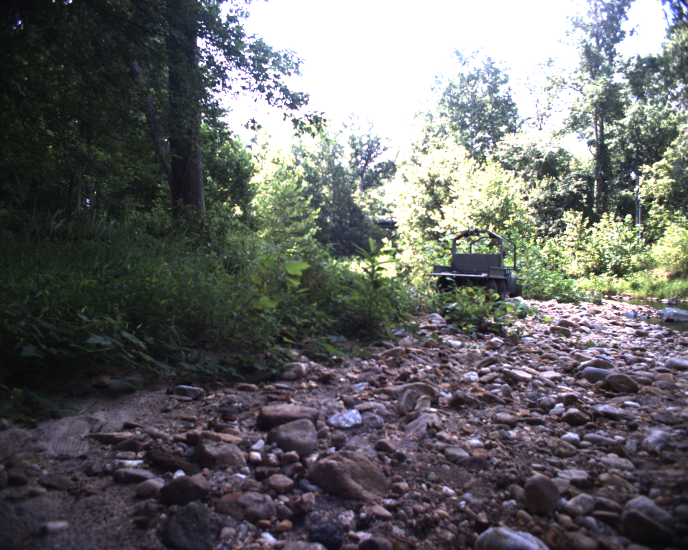

In [40]:
image = Image.open(r'C:\Users\GPUSW1\Desktop\attachments\Rugd\RUGD_frames-with-annotations\creek\creek_00001.png')
image

In [41]:
# prepare the image for the model
encoding = feature_extractor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [46]:
model1 = torch.load("rugd.pth")

In [47]:
model1.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [48]:
# forward pass
outputs = model1(pixel_values=pixel_values)

In [49]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 24, 128, 128])


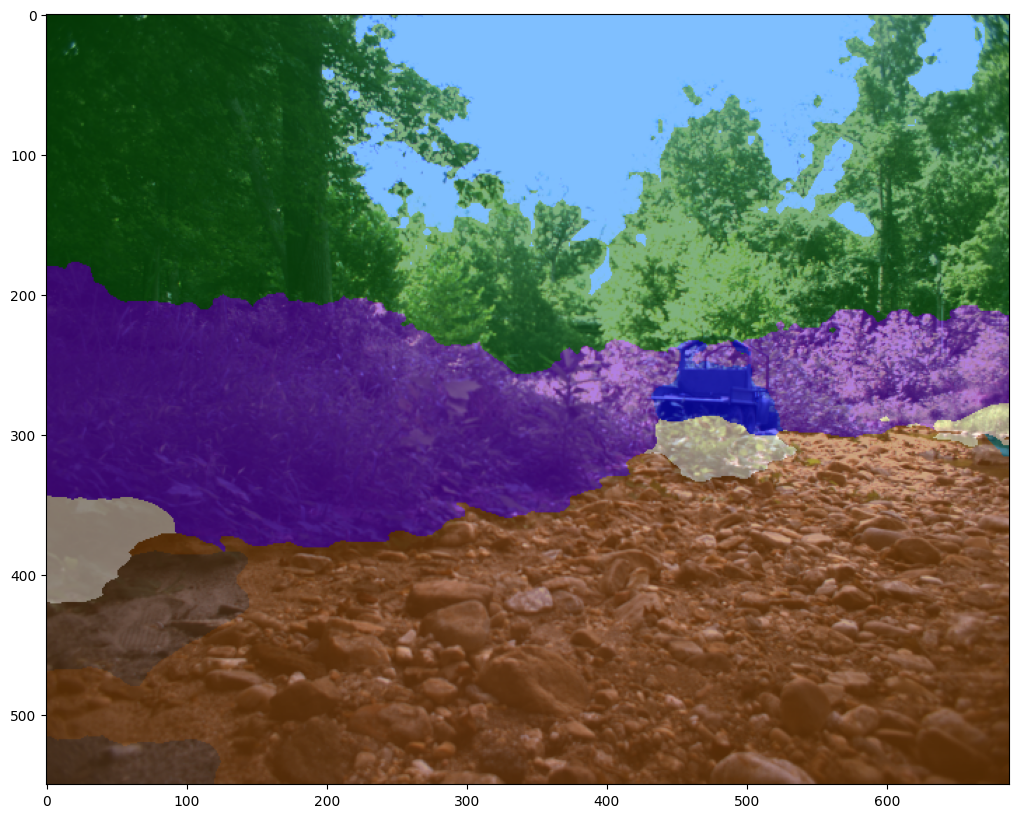

In [50]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in id2color.items():
    color_seg[seg == label, :] = color

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's print the pure predicted segmentation map:

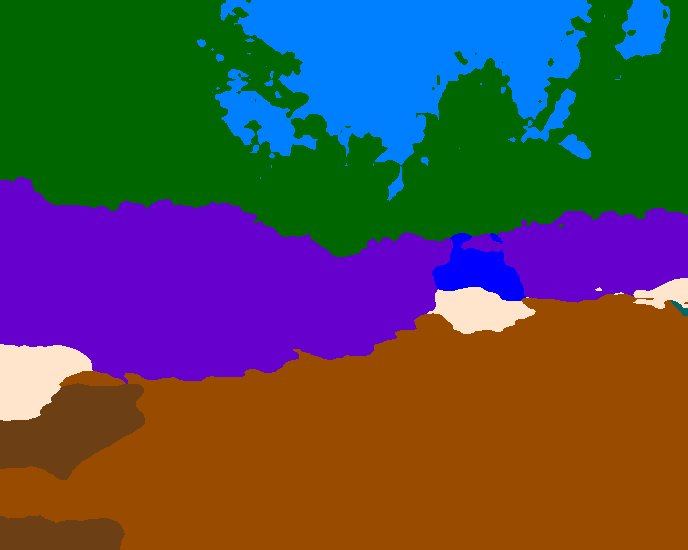

In [51]:
Image.fromarray(color_seg)

Compare this to the ground truth segmentation map:

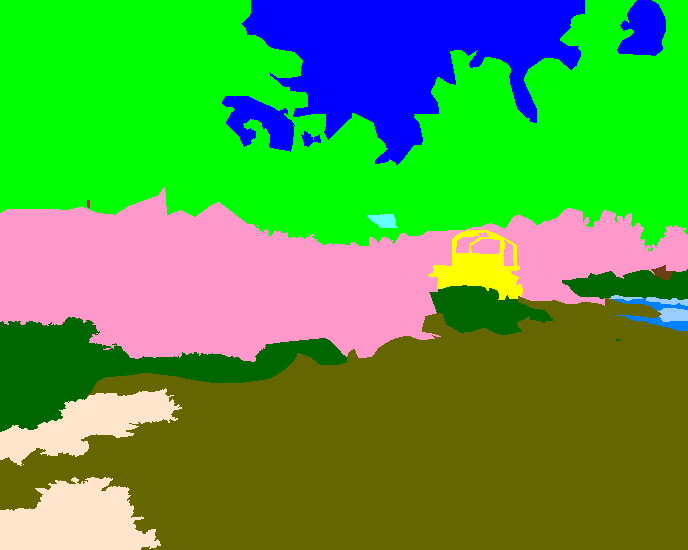

In [52]:
map = Image.open(r'C:\Users\GPUSW1\Desktop\attachments\Rugd\RUGD_annotations\RUGD_annotations\creek\creek_00001.png') 
map 